In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]


for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        nonlinear_func= LSTM_nonlinear_func(input_dim[0]).to(DEVICE)
        model = EEGNet_NeuralFS_EEG_Wrapper(DEVICE, classifier, input_dim[0],
                                    nonlinear_func=nonlinear_func
                                     ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


#         train_func= eeg_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-e{EPOCH}.pt"
#                )
#         )

#         pickle.dump( model.return_pairwise_weights(), 
#                     open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "wb") 
#                    )    

    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
#     pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-NFS_EEG.pkl","wb"))


tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


106 21

c0_acc 0.954954954954955 , c1_acc 0.42 , b_acc 0.6874774774774774
110 8

c0_acc 0.9565217391304348 , c1_acc 0.1509433962264151 , b_acc 0.5537325676784249
117 6

c0_acc 0.9512195121951219 , c1_acc 0.11320754716981132 , b_acc 0.5322135296824666
115 11

c0_acc 0.8778625954198473 , c1_acc 0.19642857142857142 , b_acc 0.5371455834242094
109 8

c0_acc 0.9316239316239316 , c1_acc 0.16326530612244897 , b_acc 0.5474446188731903
120 4

c0_acc 0.96 , c1_acc 0.08 , b_acc 0.52
113 12

c0_acc 0.904 , c1_acc 0.21428571428571427 , b_acc 0.5591428571428572
123 7

c0_acc 0.9761904761904762 , c1_acc 0.11864406779661017 , b_acc 0.5474172719935432
130 7

c0_acc 0.9774436090225563 , c1_acc 0.12727272727272726 , b_acc 0.5523581681476418
127 7

c0_acc 0.9844961240310077 , c1_acc 0.11864406779661017 , b_acc 0.5515700959138089
102 12

c0_acc 0.8571428571428571 , c1_acc 0.25 , b_acc 0.5535714285714286
115 19

c0_acc 0.9426229508196722 , c1_acc 0.35185185185185186 , b_acc 0.647237401335762
121 11

c0_acc 0

     accuracy  f1-score
S01  0.788820  0.765777
S02  0.702381  0.634239
S03  0.698864  0.625400
S04  0.673797  0.633064
S05  0.704819  0.648130
S06  0.708571  0.627843
S07  0.690608  0.646283
S08  0.702703  0.621339
S09  0.728723  0.654446
S10  0.712766  0.630480
S11  0.682635  0.655211
S12  0.761364  0.731885
S13  0.737430  0.675149
S14  0.723757  0.671054
S15  0.710383  0.634917
S16  0.699454  0.602885
S17  0.740964  0.723279
S19  0.695652  0.612583
S20  0.755556  0.711481


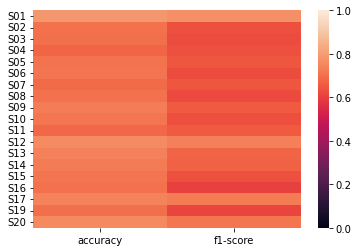

     class0 f1-score  class1 f1-score
S01         0.861789         0.552632
S02         0.814815         0.242424
S03         0.815331         0.184615
S04         0.790378         0.265060
S05         0.816479         0.246154
S06         0.824742         0.135593
S07         0.801418         0.300000
S08         0.817276         0.202899
S09         0.836013         0.215385
S10         0.824675         0.205882
S11         0.793774         0.311688
S12         0.845588         0.475000
S13         0.837370         0.318841
S14         0.826389         0.324324
S15         0.822742         0.208955
S16         0.819672         0.098361
S17         0.827309         0.481928
S19         0.813333         0.176471
S20         0.846154         0.405405


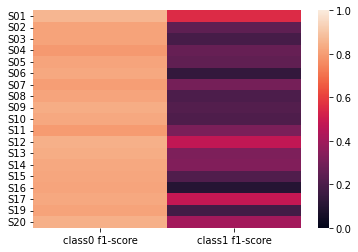

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [8]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

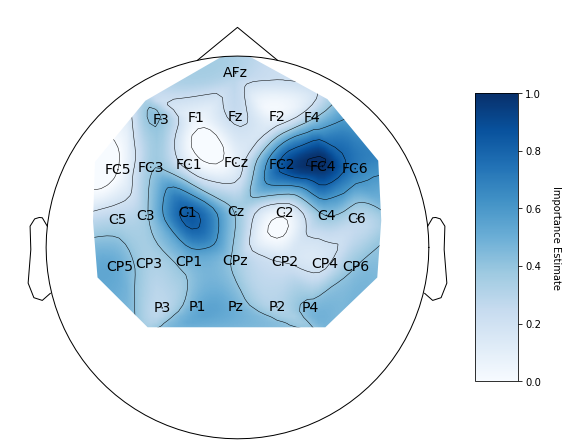

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)